In [1]:
import os
import sys 

import matplotlib.pyplot as plt
import pandas as pd
import pickle as pkl
import tensorflow as tf
from skimage import io
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, recall_score, precision_score
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator,
    img_to_array,
    load_img
)

from data_generator_3d import *
from model import *
from plotting_helpers import plot_auc

print(tf.__version__)

1.14.0


In [2]:
image_generator = ImageDataGenerator(
#     rotation_range=5,
    rescale=1./255,
#     shear_range=.1, 
#     zoom_range=.05,
    brightness_range=[.85, 1.0],
#     zca_whitening=True,
    horizontal_flip=True,
    vertical_flip=True,
    height_shift_range=5,
    width_shift_range=5,
    fill_mode='nearest',
    validation_split=0.0
)

label_generator = ImageDataGenerator(
    validation_split=0.0
)

train_generator = generator(
    base_directory='data/nlst_train/image_roi_3d',
    input_gen=image_generator,
    target_gen=label_generator,
    batch_sz=1
)

val_generator = generator(
    base_directory='data/nlst_val/image_roi_3d',
    input_gen=image_generator,
    target_gen=label_generator,
    batch_sz=1
)

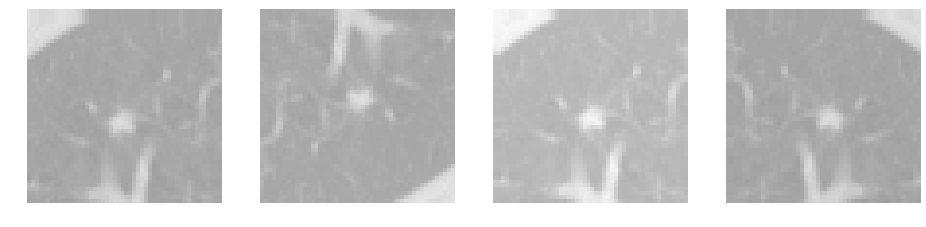

In [3]:
show_augmentation('data/nlst_train/image_roi_3d/25/0.tif', image_generator, n_rows=1)

In [2]:
model = CNN_3D(input_shape=(50, 50, 50, 1))

model.compile(
    optimizer = tf.keras.optimizers.Adam(lr = 1e-4),
    loss=weighted_cross_entropy,
    metrics = [
        'accuracy',
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall()
    ]
)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [3]:
# model.summary()

In [4]:
# model_history = model.fit_generator(
#     train_generator,
#     validation_data= val_generator,
#     validation_steps=200,
#     steps_per_epoch=1000,
#     epochs = 10
# )

In [5]:
# model.save('nlst_cnn.hdf5') 

In [6]:
model.load_weights('nlst_cnn_curbest.hdf5')
# model.load_weights('nlst_cnn.hdf5')

In [7]:
Xs = []
Ys = []
for im in os.listdir('data/nlst_test/image_roi_3d/pkls/'):
    path = f'data/nlst_test/image_roi_3d/pkls/{im}'
    with open(path, 'rb') as input_file:
        cube, label = pkl.load(input_file)
    cube = cube[:50][:50][:50]
    if cube.shape[0] < 50 or cube.shape[1] < 50 or cube.shape[2] < 50:
        pass
    else:
        Xs.append(np.array(cube/255).reshape(50, 50, 50, 1))
        Ys.append(label)

0.7272727272727273
0.5992887890698109


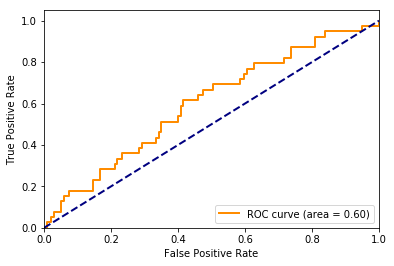

In [8]:
Xs = np.array(Xs)
Ys = np.array(Ys)
preds = np.concatenate([model.predict(Xs[i*5:min((i+1)*5, 177)]) for i in range(36)])
print(accuracy_score(Ys, np.round(preds)))
print(roc_auc_score(Ys, preds))

fig, ax = plt.subplots(1, 1)
plot_auc(Ys, preds, ax)

# Patient Model

In [9]:
df = pd.read_csv('data/nlst_patient_table.csv')
df.head()

,pid,recurrence,adjuvent,age,gender,stage 1a,stage 1b,stage 2a,stage 2b,stage 3a,stage 3b,stage 4
0,100012,1.0,0,61,2,1,0,0,0,0,0,0
1,100242,1.0,0,60,2,1,0,0,0,0,0,0
2,100280,0.0,0,60,2,1,0,0,0,0,0,0
3,100570,0.0,0,63,1,1,0,0,0,0,0,0
4,100658,0.0,0,60,1,0,1,0,0,0,0,0


In [10]:
df['stage 1'] = np.logical_or(df['stage 1a'], df['stage 1b'])
df['stage 2'] = np.logical_or(df['stage 2a'], df['stage 2b'])
df['stage 3'] = np.logical_or(df['stage 3a'], df['stage 3b'])

In [11]:
mean_preds = []
highest_preds = []
for pid in df.pid:
    preds = []
    if not os.path.exists(f'data/nlst_rois_3d/{pid}'):
        df = df[df.pid != pid]
        continue
    rois = os.listdir(f'data/nlst_rois_3d/{pid}')
    for roi in rois:
        r = pkl.load(open(f'data/nlst_rois_3d/{pid}/{roi}', 'rb'))
        if min(list(r.shape)) < 50: 
            continue
        preds.append(model.predict(np.array(r[:50]/255).reshape(1, 50, 50, 50, 1)))
    preds = sorted(preds, key=lambda x: abs(x-.5), reverse=True)
    highest_preds.append(np.array(preds[:1]).mean())
    mean_preds.append(np.array(preds).mean())
    
df['mean_pred'] = mean_preds
df['highest_pred'] = highest_preds

geometric_data = pkl.load(open(f'data/geometric_data.pkl', 'rb'))
areas = []
perimiters = []
diameters = []
avg_attenuation = []
for pid in df.pid:
    ar, pr, di, at = geometric_data[str(pid)]
    areas.append(ar)
    perimiters.append(pr)
    diameters.append(di)
    avg_attenuation.append(at)
df['area'] = areas
df['perimeter'] = perimiters
df['diameter'] = diameters
df['avg_attenuation'] = avg_attenuation

scaler = preprocessing.MinMaxScaler()
df['area'] = scaler.fit_transform(np.array(areas).reshape(-1,1)).reshape(-1,1).reshape(1, -1)[0]
df['perimeter'] = scaler.fit_transform(np.array(perimiters).reshape(-1,1)).reshape(-1,1).reshape(1, -1)[0]
df['diameter'] = scaler.fit_transform(np.array(diameters).reshape(-1,1)).reshape(-1,1).reshape(1, -1)[0]
df['avg_attenuation'] = scaler.fit_transform(np.array(avg_attenuation).reshape(-1,1)).reshape(-1,1).reshape(1, -1)[0]

train_ids = pkl.load(open('data/train_ids.pkl', 'rb'))
test_ids = pkl.load(open('data/test_ids.pkl', 'rb'))

df['train'] = [int(pid in train_ids) for pid in df.pid]
df['test'] = [int(pid in test_ids) for pid in df.pid]

df_train = df[df.train == 1]
df_test = df[df.test == 1]

Patient accuracy (using mean score):    0.7076923076923077
Patient accuracy (using highest value): 0.6923076923076923

Patient AUC (using mean score):    0.6182033096926713
Patient AUC (using highest value): 0.6524822695035462


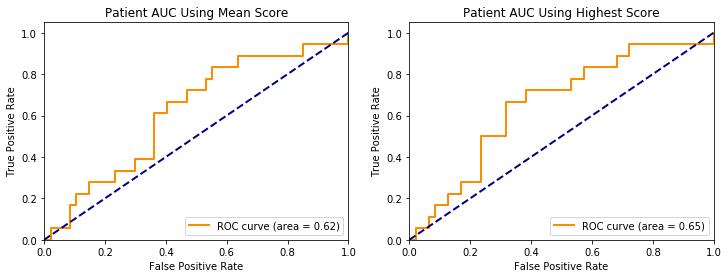

In [12]:
print("Patient accuracy (using mean score):    " + str(accuracy_score(df_test.recurrence, np.round(df_test.mean_pred))))
print("Patient accuracy (using highest value): " + str(accuracy_score(df_test.recurrence, np.round(df_test.highest_pred))))

print("\nPatient AUC (using mean score):    " + str(roc_auc_score(df_test.recurrence, list(df_test.mean_pred))))
print("Patient AUC (using highest value): " + str(roc_auc_score(df_test.recurrence, list(df_test.highest_pred))))

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
plot_auc(df_test.recurrence, df_test.mean_pred, axs[0])
plot_auc(df_test.recurrence, df_test.highest_pred, axs[1])

axs[0].set_title("Patient AUC Using Mean Score")
axs[1].set_title("Patient AUC Using Highest Score")

# print(recall_score(list(Patient_Ys.values()), np.round(list(patient_preds_mean.values()))))
# print(precision_score(list(Patient_Ys.values()), np.round(list(patient_preds_greatest.values()))))

plt.show()

In [73]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [112]:
def evaluate(features):
    X = df_train[features]
    Y = df_train.recurrence
    clf = RandomForestClassifier(n_estimators=100, random_state=3)
#     clf = DecisionTreeClassifier(random_state=3)
    clf.fit(X, Y)
    
    importances = clf.feature_importances_
    sorted_indices = np.argsort(importances)[::-1][:5]
    sorted_importances = [importances[i] for i in sorted_indices]

    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    x = range(1, 6)
    ax.bar(x, sorted_importances)
    ax.set_ylabel('Relative Importance')
    ax.set_xticks(range(1, 6))
    ax.set_xticklabels([X.columns[i] for i in sorted_indices])
    plt.show()
    
    y_pred = clf.predict_proba(df_test[features])[:, 1]
    print(f'Overall Accuracy: {accuracy_score(df_test.recurrence, np.round(y_pred))}')
    print(f'Overall AUC: {roc_auc_score(df_test.recurrence, y_pred)}')
    print(f'Overall Recalll: {recall_score(df_test.recurrence, np.round(y_pred))}')
    print(f'Overall Precision: {precision_score(df_test.recurrence, np.round(y_pred))}')
    
    df_stage1 = df_test[np.logical_or(df_test['stage 1b'], df_test['stage 1a'])]
    y_pred_1 = clf.predict_proba(df_stage1[features])[:, 1] 
    print(f'Stage 1 Accuracy: {accuracy_score(df_stage1.recurrence, np.round(y_pred_1))}')
    print(f'Stage 1 AUC: {roc_auc_score(df_stage1.recurrence, y_pred_1)}')
    print(f'Stage 1 Recalll: {recall_score(df_stage1.recurrence, np.round(y_pred_1))}')
    print(f'Stage 1 Precision: {precision_score(df_stage1.recurrence, np.round(y_pred_1))}')
    
    df_stage2 = df_test[np.logical_or(df_test['stage 2b'], df_test['stage 2a'])]
    y_pred_2 = clf.predict_proba(df_stage2[features])[:, 1]
    print(f'Stage 2 Accuracy: {accuracy_score(df_stage2.recurrence, np.round(y_pred_2))}')
    print(f'Stage 2 AUC: {roc_auc_score(df_stage2.recurrence, y_pred_2)}')
    print(f'Stage 2 Recalll: {recall_score(df_stage2.recurrence, np.round(y_pred_2))}')
    print(f'Stage 2 Precision: {precision_score(df_stage2.recurrence, np.round(y_pred_2))}')
    

Staging + Adjuvent


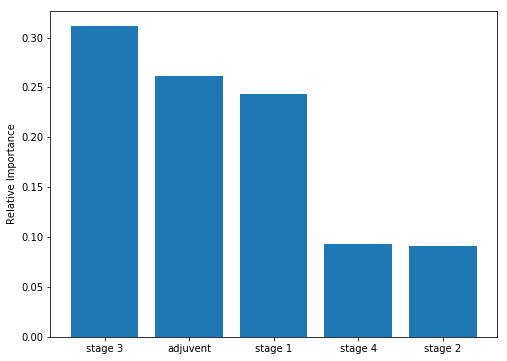

Overall Accuracy: 0.7384615384615385
Overall AUC: 0.6684397163120567
Overall Recalll: 0.16666666666666666
Overall Precision: 0.6
Stage 1 Accuracy: 0.7818181818181819
Stage 1 AUC: 0.5164728682170543
Stage 1 Recalll: 0.0
Stage 1 Precision: 0.0
Stage 2 Accuracy: 0.5
Stage 2 AUC: 0.6666666666666667
Stage 2 Recalll: 1.0
Stage 2 Precision: 0.3333333333333333


Staging + Adjuvent + Max Area + NN


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples.



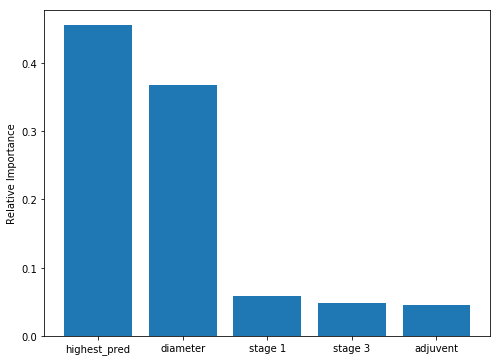

Overall Accuracy: 0.8
Overall AUC: 0.7056737588652482
Overall Recalll: 0.5
Overall Precision: 0.6923076923076923
Stage 1 Accuracy: 0.7818181818181819
Stage 1 AUC: 0.5872093023255814
Stage 1 Recalll: 0.25
Stage 1 Precision: 0.5
Stage 2 Accuracy: 0.75
Stage 2 AUC: 0.6666666666666667
Stage 2 Recalll: 1.0
Stage 2 Precision: 0.5


In [113]:
# print("Staging + Adjuvent")
# evaluate([
#     'adjuvent', 'stage 1a', 'stage 2a', 'stage 3a', 'stage 1b', 'stage 2b', 'stage 3b',
#     'stage 4'
# ])

# print()
# print("\nStaging + Adjuvent + Max Area + NN")
# evaluate([
#     'adjuvent', 'stage 1a', 'stage 1b', 'stage 2a',
#     'stage 2b', 'stage 3a', 'stage 3b', 'stage 4', 
#     'highest_pred', 'avg_attenuation', 'diameter'
# ])


print("Staging + Adjuvent")
evaluate([
    'adjuvent', 'stage 1', 'stage 2', 'stage 3','stage 4'
])

print()
print("\nStaging + Adjuvent + Max Area + NN")
evaluate([
    'adjuvent', 'stage 1', 'stage 2', 'stage 3',
    'stage 4', 'highest_pred', 'diameter',
    'avg_attenuation', 'perimeter'x
])